This notebook answers a few basics questions about the COSMOS field data-- how many objects and candidates were detected, how objects are distributed among candidates, and how those distributions change when an R/B cutoff is applied.

In [2]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [4]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [5]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How many standard images are in the COSMOS field?

In [44]:
query = ( 'SELECT e.filename, e.filter FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

expnumquery = np.array(cursor.fetchall()).transpose()

In [45]:
# truncate filenames to match lookup table format
fnms = [ expnumquery[0][i][:21] for i in range( len( expnumquery[0] ) ) ]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [46]:
filters = np.array(expnumquery[1])

# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
len(grimsk)

1040

#### How many objects total in the COSMOS field?

In [24]:
query = ( 'SELECT o.id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

objnum = pd.DataFrame(cursor.fetchall(), columns=["ObjID", "Fnm", "Filter"])
# print( objnum )

In [25]:
# Grab lookup table for exposure times
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7]

# truncate filenames to match lookup table format
fnms = [objnum["Fnm"][i][:21] for i in range(len(objnum["Fnm"]))]

In [26]:
# find the exposure time for each object
exptime = [exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]
objnum["Exptime"] = np.array(exptime).astype(float)

In [27]:
# Eliminate objects from non-standard images
gmsk = np.where((objnum["Filter"]=="g") & (objnum["Exptime"]>50))[0]
rmsk = np.where((objnum["Filter"]=="r") & (objnum["Exptime"]>20))[0]
imsk = np.where((objnum["Filter"]=="i") & (objnum["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [28]:
# length of resulting mask is the total number of objects from science images
len(grimsk)

1348785

#### How many good (R/B>0.6) objects total in the COSMOS field?

In [169]:
query = ( 'SELECT o.id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000')
cursor.execute( query )

objnumdf = pd.DataFrame(cursor.fetchall(), columns=["ObjID", "Fnm", "Filter"])

In [170]:
len(objnumdf["ObjID"]) # total number of good objects

123757

In [171]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [objnumdf["Fnm"][i][:21] for i in range(len(objnumdf["Fnm"]))] # truncate filenames to match lookup table format

In [172]:
# find the exposure time for each object
objnumdf["Exptime"] = [exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]

In [173]:
# Eliminate objects from non-standard images
gmsk = np.where((objnumdf["Filter"]=="g") & (objnumdf["Exptime"]>50))[0]
rmsk = np.where((objnumdf["Filter"]=="r") & (objnumdf["Exptime"]>20))[0]
imsk = np.where((objnumdf["Filter"]=="i") & (objnumdf["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [174]:
objnum = len(grimsk) # number of good objects from standard images

#### How many candidates total in the COSMOS field?

In [153]:
# Not sure how I would go about eliminating candidates with detections only in non-standard images, but I imagine that fraction is negligible?
query = ( 'SELECT COUNT(*) FROM candidates c '
         'WHERE q3c_radial_query(c.ra,c.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

candnum = cursor.fetchall()[0][0]
print( candnum )

188166


#### How are the objects distributed among candidates (COSMOS, ignoring RB scores)?

In [155]:
### Returns objects.candidate_id for every object

query = ( 'SELECT candidate_id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

cndobj_a = np.array( cursor.fetchall() ).transpose()
cndobj_a

array([['DC21e', 'DC21c', 'DC21f', ..., 'DC21mmu', 'DC21ttw', 'DC21dahl']],
      dtype='<U9')

In [156]:
# Finding out how many objects have a given candidate id
candidate_a, frequencies_a = np.unique( cndobj_a[0], return_counts=True )

In [157]:
pd.DataFrame( frequencies_a, candidate_a, columns=["Number of detections"]) # visualization

,Number of detections
DC21b,145
DC21ba,134
DC21baa,37
DC21baaa,31
DC21baab,24
...,...
DC21zzv,69
DC21zzw,1
DC21zzx,78
DC21zzy,20


THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700
It also includes every object, regardless of rb score


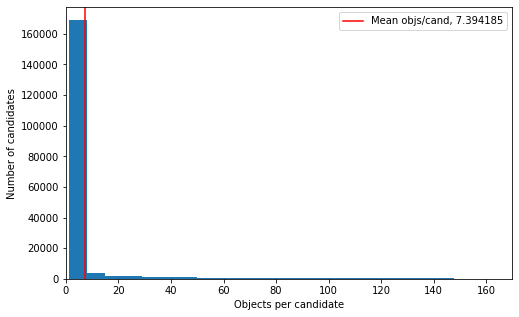

In [158]:
# Plotting it up
plt.figure( figsize=(8,5) )
plt.hist( frequencies_a, bins=100 )
plt.xlim( 0, 170 )
plt.xlabel( "Objects per candidate" )
plt.ylabel( "Number of candidates" )
plt.axvline( np.mean( frequencies_a ), label="Mean objs/cand, %f" % (np.mean(frequencies_a)), color='r' )
plt.legend()
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700" )
print( "It also includes every object, regardless of rb score" )

#### Same analysis, but for only "good" object detections (COSMOS, R/B>0.6)

In [176]:
query = ( 'SELECT candidate_id, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

cndobj_g = np.array( cursor.fetchall() ).transpose()
cndobj_g

array([['DC21g', 'DC21j', 'DC21bd', ..., 'DC21bivgh', 'DC21bivgn',
        'DC21eamv'],
       ['c4d_210319_002223_ori.fits.fz', 'c4d_210319_002223_ori.fits.fz',
        'c4d_210319_002223_ori.fits.fz', ...,
        'c4d_210611_001044_ori.fits.fz', 'c4d_210611_001044_ori.fits.fz',
        'c4d_210611_001044_ori.fits.fz']], dtype='<U29')

In [177]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [cndobj_g[1][i][:21] for i in range(len(cndobj_g[1]))] # truncate filenames to match lookup table format

In [178]:
# find the exposure time for each object
exptime = [exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]

In [179]:
# Eliminate objects from non-standard images
gmsk = np.where((objnumdf["Filter"]=="g") & (exptime>50))[0]
rmsk = np.where((objnumdf["Filter"]=="r") & (exptime>20))[0]
imsk = np.where((objnumdf["Filter"]=="i") & (exptime>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [180]:
# Finding out how many objects have a given candidate id
candidate_g, frequencies_g = np.unique( cndobj_g[0][grimsk], return_counts=True )

THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350
It includes only objects with rb scores above 0.6


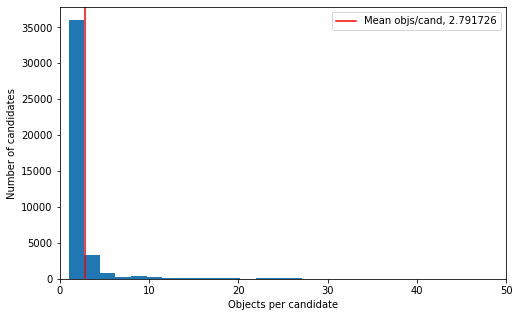

In [182]:
# Plotting it up
plt.figure( figsize=(8,5) )
plt.hist( frequencies_g, bins=200 )
plt.xlim( 0, 50 )
plt.xlabel( "Objects per candidate" )
plt.ylabel( "Number of candidates" )
plt.axvline( np.mean( frequencies_g ), label="Mean objs/cand, %f" % ( np.mean(frequencies_g) ), color='r' )
plt.legend()
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350" )
print( "It includes only objects with rb scores above 0.6" )

#### How are objects.magnitude values correlated with objects.magerr values?

In [6]:
query = ( 'SELECT o.mag, o.magerr, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON s.id = o.subtraction_id '
         'JOIN exposures e ON e.id = s.exposure_id '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000')
cursor.execute( query )

magverr = np.array(cursor.fetchall()).transpose()

In [7]:
### Limiting to standard exposure times

# truncate filenames to match lookup table format
fnms = [ magverr[2][i][:21] for i in range( len( magverr[2] ) ) ]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

filters = np.array(magverr[3])

# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
magverr = magverr.transpose()[grimsk].transpose()

Text(0, 0.5, 'Magerr')

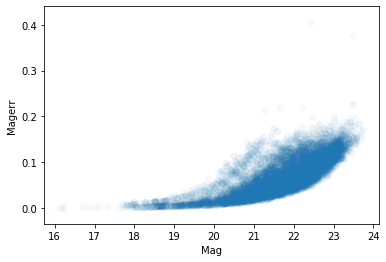

In [13]:
# Put in a random seed
np.random.seed(40)
rand = np.random.randint(0, high=len(magverr[0]), size=10000)
plt.scatter(magverr[0].astype(float)[rand], magverr[1].astype(float)[rand], alpha = 0.03)
plt.xlabel("Mag")
plt.ylabel("Magerr")